<a href="https://colab.research.google.com/github/danikagupta/DeepTextile/blob/main/patch_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



=== Processing class: Cotton ===


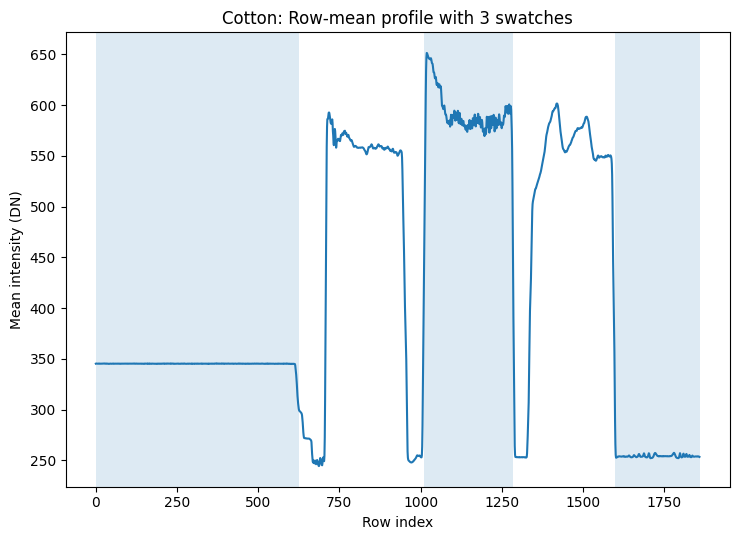

/tmp/ipython-input-988137837.py:130: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Rc = (S_cube - Dv) / (Wv - Dv + eps)


Saved: /content/drive/Shareddrives/Danika-work4/Textile/patches_new/cotton_patch_spectra.csv | rows: 240 | bands: 214

=== Processing class: Polyester ===


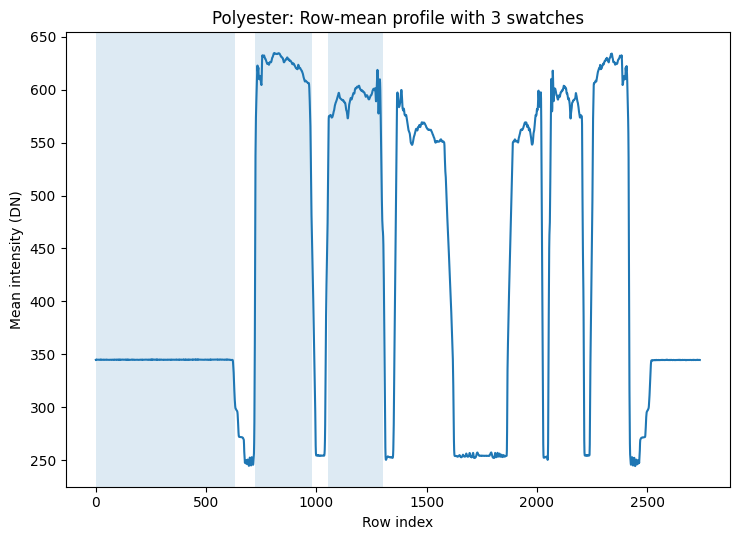

/tmp/ipython-input-988137837.py:130: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Rc = (S_cube - Dv) / (Wv - Dv + eps)


Saved: /content/drive/Shareddrives/Danika-work4/Textile/patches_new/polyester_patch_spectra.csv | rows: 240 | bands: 214

=== Processing class: Nylon ===


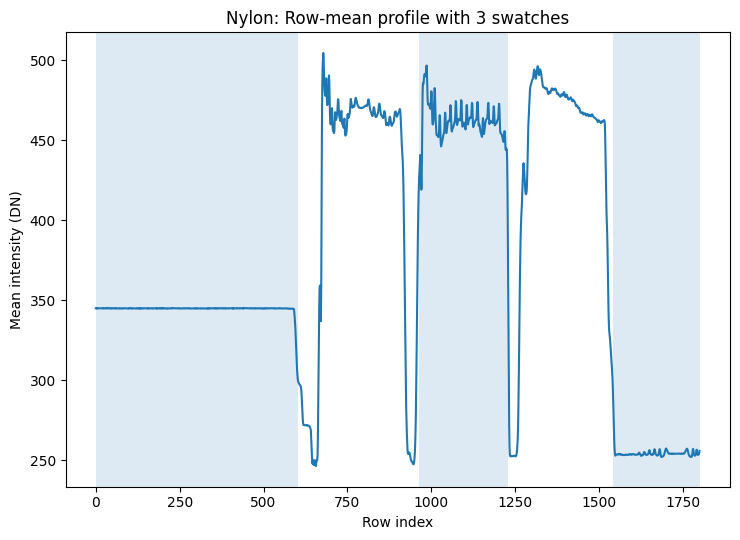

/tmp/ipython-input-988137837.py:130: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Rc = (S_cube - Dv) / (Wv - Dv + eps)


Saved: /content/drive/Shareddrives/Danika-work4/Textile/patches_new/nylon_patch_spectra.csv | rows: 240 | bands: 214

=== Processing class: Cotton–Poly Blend ===


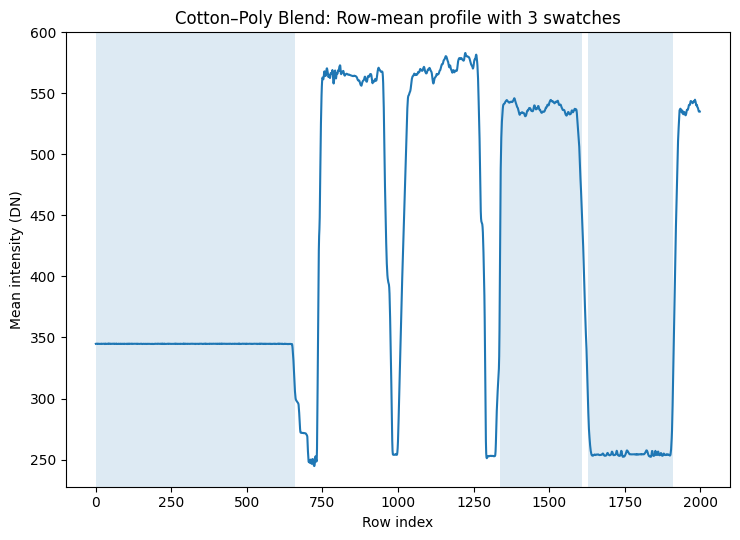

/tmp/ipython-input-988137837.py:130: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Rc = (S_cube - Dv) / (Wv - Dv + eps)


Saved: /content/drive/Shareddrives/Danika-work4/Textile/patches_new/cotton–poly_blend_patch_spectra.csv | rows: 240 | bands: 214

=== Processing class: Poly–Spandex Blend ===


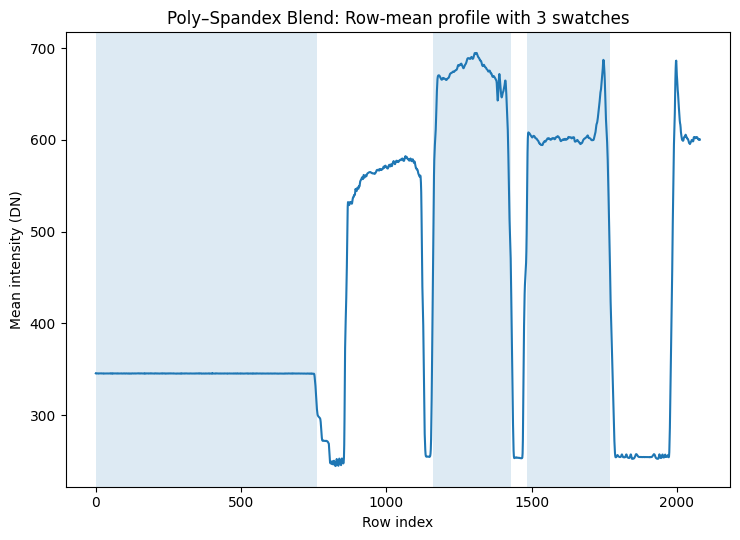

/tmp/ipython-input-988137837.py:130: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Rc = (S_cube - Dv) / (Wv - Dv + eps)


Saved: /content/drive/Shareddrives/Danika-work4/Textile/patches_new/poly–spandex_blend_patch_spectra.csv | rows: 240 | bands: 214

Saved combined: /content/drive/Shareddrives/Danika-work4/Textile/patches_new/all_classes_patch_spectra.csv | rows: 1200 | bands: 214

All done. Outputs in: /content/drive/Shareddrives/Danika-work4/Textile/patches_new


In [3]:
# ============================================
# DeepTextile: Generate Patch-Level Spectra CSVs
# (from HDR cubes with automatic 3-swatch segmentation)
# ============================================

!pip -q install spectral numpy matplotlib pandas scikit-learn

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spectral as spy
from sklearn.cluster import KMeans

# Optional: lower ENVI header warnings
import spectral
spectral.settings.envi_support_nonlowercase_params = True

plt.rcParams['figure.figsize'] = (7.5, 5.5)
plt.rcParams['savefig.dpi'] = 300

# ---------- CONFIG (EDIT THESE) ----------
OUTDIR = "/content/drive/Shareddrives/Danika-work4/Textile/patches_new"

# Map each class to its ENVI paths
# Replace the dummy paths with your actual files.
CLASSES = {
    "Cotton": {
        "sample_hdr": "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Fab_100Cotton/capture/Joann_Fab_100Cotton.hdr",
        "white_hdr":  "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Fab_100Cotton/capture/WHITEREF_Joann_Fab_100Cotton.hdr",
        "dark_hdr":   "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Fab_100Cotton/capture/DARKREF_Joann_Fab_100Cotton.hdr",
    },
    "Polyester": {
        "sample_hdr": "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Fab_100Poly_0002/capture/Joann_Fab_100Poly_0002.hdr",
        "white_hdr":  "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Fab_100Poly_0002/capture/WHITEREF_Joann_Fab_100Poly_0002.hdr",
        "dark_hdr":   "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Fab_100Poly_0002/capture/DARKREF_Joann_Fab_100Poly_0002.hdr",
    },
    "Nylon": {
        "sample_hdr": "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Nylon/capture/Joann_Nylon.hdr",
        "white_hdr":  "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Nylon/capture/WHITEREF_Joann_Nylon.hdr",
        "dark_hdr":   "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Nylon/capture/DARKREF_Joann_Nylon.hdr",
    },
    "Cotton–Poly Blend": {
        "sample_hdr": "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Fab_100Poly_CottonBlend/capture/Joann_Fab_100Poly_CottonBlend.hdr",
        "white_hdr":  "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Fab_100Poly_CottonBlend/capture/WHITEREF_Joann_Fab_100Poly_CottonBlend.hdr",
        "dark_hdr":   "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Fab_100Poly_CottonBlend/capture/DARKREF_Joann_Fab_100Poly_CottonBlend.hdr",
    },
    "Poly–Spandex Blend": {
        "sample_hdr": "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Poly_Spand/capture/Joann_Poly_Spand.hdr",
        "white_hdr":  "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Poly_Spand/capture/WHITEREF_Joann_Poly_Spand.hdr",
        "dark_hdr":   "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Poly_Spand/capture/DARKREF_Joann_Poly_Spand.hdr",
    },
}



# Layout of the 3 swatches inside each sample cube:
# "auto" chooses 'row' if rows >= 3 else 'col'
LAYOUT_AXIS = "auto"   # "auto" | "row" | "col"

# Trim a few noisy bands from each end (set to None to disable)
TRIM_BANDS = (5, -5)

# Patch sampling (requested size; will auto-shrink to fit within swatch)
PATCH_SIZE_RC      = (30, 30)   # (rows, cols)
PATCHES_PER_SWATCH = 80         # per swatch (→ 240 per class)
RANDOM_SEED        = 123
# ---------- END CONFIG ----------


# ----------------- Helpers -----------------
def open_envi(hdr_path):
    img = spy.open_image(hdr_path)
    cube = img.load()
    if cube.ndim != 3:
        raise ValueError(f"Expected 3D cube, got {cube.shape} @ {hdr_path}")
    return img, cube

def wavelengths_from_hdr(img, expected_bands=None):
    """
    Robust wavelength extraction:
    - Try metadata['wavelength'] (list or string)
    - Then try img.bands.centers
    - Validate 1-D and (optionally) exact length
    Returns np.ndarray shape (bands,) or None.
    """
    wl = None
    try:
        meta_wl = img.metadata.get('wavelength', None)
        if meta_wl is not None:
            if isinstance(meta_wl, (list, tuple)):
                wl = np.array([float(x) for x in meta_wl], dtype=float)
            elif isinstance(meta_wl, str):
                s = meta_wl.strip().strip("{}[]()")
                parts = [p for p in s.replace(";", ",").split(",") if p.strip()]
                wl = np.array([float(p) for p in parts], dtype=float)
    except Exception:
        wl = None
    if wl is None and hasattr(img, 'bands') and hasattr(img.bands, 'centers'):
        try:
            wl = np.array(img.bands.centers, dtype=float)
        except Exception:
            wl = None
    if wl is None or getattr(wl, "ndim", 0) != 1:
        return None
    if expected_bands is not None and wl.size != expected_bands:
        return None
    return wl

def apply_trim(arr, trim):
    """Safe trimming for 1-D (bands) or 3-D (rows, cols, bands) arrays; otherwise return unchanged."""
    if trim is None or arr is None:
        return arr
    s, e = trim
    if isinstance(arr, (list, tuple)):
        arr = np.array(arr)
    if isinstance(arr, np.ndarray):
        if arr.ndim == 1:
            return arr[s: (None if e == 0 else e)]
        elif arr.ndim == 3:
            return arr[..., s: (None if e == 0 else e)]
    return arr

def ref_vector_from_cube(ref_cube):
    return np.asarray(ref_cube.mean(axis=(0,1)))

def calibrate_cube(S_cube, W_vec, D_vec, eps=1e-6):
    Wv = W_vec.reshape((1,1,-1))
    Dv = D_vec.reshape((1,1,-1))
    Rc = (S_cube - Dv) / (Wv - Dv + eps)
    return np.clip(Rc, 0.0, 1.0)

def rowcol_profile(S_cube, axis='row'):
    return S_cube.mean(axis=(1,2)) if axis=='row' else S_cube.mean(axis=(0,2))

def contiguous_runs_from_labels(labels):
    segs, start, cur = [], 0, labels[0]
    for i in range(1, len(labels)):
        if labels[i] != cur:
            segs.append((start, i))
            start, cur = i, labels[i]
    segs.append((start, len(labels)))
    return segs

def smart_segment_1d(profile, n_segments=3, random_state=0):
    """
    Segment a 1D profile into n contiguous runs.
    If profile long enough: KMeans -> contiguous runs -> pick n longest.
    Else: equal partitions.
    """
    L = len(profile)
    if L >= max(6, n_segments):
        X = profile.reshape(-1,1)
        km = KMeans(n_clusters=n_segments, n_init=10, random_state=random_state)
        labels = km.fit_predict(X)
        runs = contiguous_runs_from_labels(labels)
        runs = sorted(runs, key=lambda r: (r[1]-r[0]), reverse=True)[:n_segments]
        runs = sorted(runs, key=lambda r: r[0])
        return runs
    # Equal partitions fallback
    step = L / n_segments
    spans, s = [], 0.0
    for k in range(n_segments):
        e = L if k == n_segments - 1 else int(round((k + 1) * step))
        spans.append((int(round(s)), int(e)))
        s = e
    return [(a,b) for (a,b) in spans if b > a]

def choose_random_patch_within_slice(swatch_slice_rc, cube_shape, patch_size_rc, rng):
    """Pick a patch that always fits inside the swatch; shrink size when needed (down to 1x1)."""
    rows, cols, _ = cube_shape
    r_slice, c_slice = swatch_slice_rc

    r_start = r_slice.start or 0
    r_stop  = r_slice.stop  if r_slice.stop is not None else rows
    c_start = c_slice.start or 0
    c_stop  = c_slice.stop  if c_slice.stop is not None else cols

    sw_h = max(0, r_stop - r_start)
    sw_w = max(0, c_stop - c_start)
    if sw_h <= 0 or sw_w <= 0:
        raise ValueError(f"Empty swatch slice: rows={sw_h}, cols={sw_w}")

    req_h, req_w = patch_size_rc
    ph = max(1, min(req_h, sw_h))
    pw = max(1, min(req_w, sw_w))

    r0_min, r0_max = r_start, r_stop - ph
    c0_min, c0_max = c_start, c_stop - pw

    r0 = rng.integers(r0_min, r0_max + 1) if r0_max >= r0_min else r0_min
    c0 = rng.integers(c0_min, c0_max + 1) if c0_max >= c0_min else c0_min

    return (slice(r0, r0 + ph), slice(c0, c0 + pw))

def extract_patch_spectrum(cube, patch_slice):
    sub = cube[patch_slice[0], patch_slice[1], :]
    return np.asarray(sub.mean(axis=(0,1)))

def band_column_names(wavelengths_or_indices):
    """Return nice column names for bands, using wavelengths if available."""
    arr = np.asarray(wavelengths_or_indices)
    if arr.ndim == 1 and np.issubdtype(arr.dtype, np.number):
        # Use nm if looks like wavelengths; else band index
        if arr.max() > 50:  # heuristic: looks like nm
            return [f"wl_{int(round(x))}nm" for x in arr]
        else:
            return [f"band_{i+1:03d}" for i in range(arr.size)]
    else:
        # fallback to band indices
        return [f"band_{i+1:03d}" for i in range(len(arr))]
# ----------------- End helpers -----------------


# ----------------- Main: build per-class & combined CSVs -----------------
os.makedirs(OUTDIR, exist_ok=True)
rng = np.random.default_rng(RANDOM_SEED)

combined_rows = []
per_class_files = []

for CLASS_NAME, paths in CLASSES.items():
    print(f"\n=== Processing class: {CLASS_NAME} ===")
    S_img, S_cube_raw = open_envi(paths["sample_hdr"])
    W_img, W_cube     = open_envi(paths["white_hdr"])
    D_img, D_cube     = open_envi(paths["dark_hdr"])

    # Vector refs (often one line)
    W_vec = ref_vector_from_cube(W_cube)
    D_vec = ref_vector_from_cube(D_cube)

    # Trim consistently
    S_cube = apply_trim(S_cube_raw, TRIM_BANDS)
    W_vec  = apply_trim(W_vec, TRIM_BANDS)
    D_vec  = apply_trim(D_vec, TRIM_BANDS)

    rows, cols, bands = S_cube.shape

    # Wavelengths (robust) aligned to trimmed bands
    wl = wavelengths_from_hdr(S_img, expected_bands=bands)
    if wl is None:
        wl = np.arange(bands)  # fall back to band indices
    band_cols = band_column_names(wl)

    # Decide segmentation axis
    axis = LAYOUT_AXIS
    if axis == "auto":
        axis = "row" if rows >= 3 else "col"

    # 1D profile -> 3 contiguous swatches
    prof  = rowcol_profile(S_cube, axis=axis)
    spans = smart_segment_1d(prof, n_segments=3, random_state=0)
    if axis == "row":
        swatch_slices = [(slice(a,b), slice(0, cols)) for (a,b) in spans]
        axis_name = "Row"
    else:
        swatch_slices = [(slice(0, rows), slice(a,b)) for (a,b) in spans]
        axis_name = "Col"

    # sanity plot
    plt.figure()
    plt.plot(prof)
    for (a,b) in spans:
        plt.axvspan(a, b, alpha=0.15)
    plt.title(f"{CLASS_NAME}: {axis_name}-mean profile with 3 swatches")
    plt.xlabel(f"{axis_name} index"); plt.ylabel("Mean intensity (DN)")
    plt.tight_layout()
    seg_path = os.path.join(OUTDIR, f"{CLASS_NAME.lower().replace(' ', '_')}_seg_profile.png")
    plt.savefig(seg_path); plt.show()

    # Calibrate to reflectance
    R_cube = calibrate_cube(S_cube, W_vec, D_vec, eps=1e-6)

    # Sample patches → spectra rows
    class_rows = []
    for sw_idx, sw_slice in enumerate(swatch_slices, start=1):
        for k in range(PATCHES_PER_SWATCH):
            ps   = choose_random_patch_within_slice(sw_slice, R_cube.shape, PATCH_SIZE_RC, rng)
            spec = extract_patch_spectrum(R_cube, ps)   # (bands,)

            row = {
                "id": f"{CLASS_NAME}_S{sw_idx}_p{k:03d}",
                "class": CLASS_NAME,
                "swatch": f"Swatch {sw_idx}",
            }
            # add spectral columns
            for c, v in zip(band_cols, spec.tolist()):
                row[c] = float(v)

            class_rows.append(row)
            combined_rows.append(row)

    # Save per-class CSV
    df_class = pd.DataFrame(class_rows, columns=["id", "class", "swatch"] + band_cols)
    out_csv = os.path.join(OUTDIR, f"{CLASS_NAME.lower().replace(' ', '_')}_patch_spectra.csv")
    df_class.to_csv(out_csv, index=False)
    per_class_files.append(out_csv)
    print("Saved:", out_csv, "| rows:", len(df_class), "| bands:", len(band_cols))

# Save combined CSV
df_all = pd.DataFrame(combined_rows, columns=["id", "class", "swatch"] + band_cols)
combined_csv = os.path.join(OUTDIR, "all_classes_patch_spectra.csv")
df_all.to_csv(combined_csv, index=False)
print("\nSaved combined:", combined_csv, "| rows:", len(df_all), "| bands:", len(band_cols))

# Manifest
manifest = {
    "outdir": OUTDIR,
    "trim_bands": TRIM_BANDS,
    "patch_size_rc": PATCH_SIZE_RC,
    "patches_per_swatch": PATCHES_PER_SWATCH,
    "layout_axis": LAYOUT_AXIS,
    "per_class_csvs": per_class_files,
    "combined_csv": combined_csv,
    "segmentation_profiles": [f for f in os.listdir(OUTDIR) if f.endswith("_seg_profile.png")],
    "band_columns": band_cols[:5] + (["..."] if len(band_cols) > 5 else []),
}
with open(os.path.join(OUTDIR, "patch_manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)

print("\nAll done. Outputs in:", OUTDIR)
